In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import BGTools as bgt

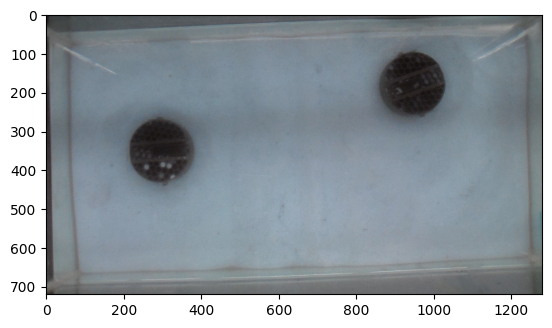

In [2]:
background = bgt.BGExtraction("Video1.MP4", 0)
plt.imshow(background)

# Circle Detection

In [3]:
BGCircles = bgt.BurrowDetection(background, 2)
centers = []
radius = []
for i in range(len(BGCircles)):
    centers.append((BGCircles[i][0], BGCircles[i][1]))
    radius.append(BGCircles[i][2])


BGCircles

array([[294, 352,  81],
       [948, 180,  83]])

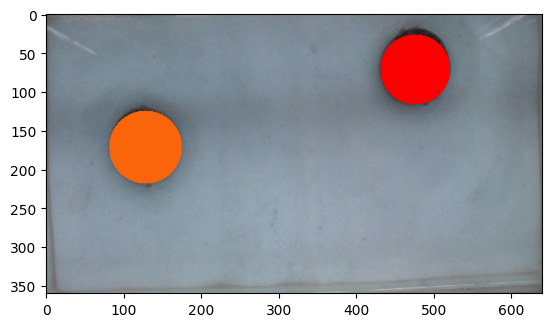

In [36]:
for i in range(len(BGCircles)):
    #cv.circle(background, (BGCircles[i][0], BGCircles[i][1]), BGCircles[i][2]+50, (150, 100*i, 10*i), -1)
    cv.circle(background, (BGCircles[i][0], BGCircles[i][1]), BGCircles[i][2], (250, 100*i, 10*i), -1)

plt.imshow(background)

# Tracking

## Background Subtraction

In [5]:
for i in range(5):
    bgt.VideoClip("Video2.MP4", "Trial{0}.avi".format(i), i*90000, (i+1)*90000)

In [5]:
import threading

def function0():
    processed0 = bgt.BackgroundSubtraction("Trial0.avi", background, "Trial0BW.avi", 0)

def function1():
    processed1 = bgt.BackgroundSubtraction("Trial1.avi", background, "Trial1BW.avi", 0)

def function2():
    processed2 = bgt.BackgroundSubtraction("Trial2.avi", background, "Trial2BW.avi", 0)

def function3():
    processed3 = bgt.BackgroundSubtraction("Trial3.avi", background, "Trial3BW.avi", 0)

def function4():
    processed4 = bgt.BackgroundSubtraction("Trial4.avi", background, "Trial4BW.avi", 0)

if __name__ == '__main__':
    # Create threads
    t0 = threading.Thread(target=function0)
    t1 = threading.Thread(target=function1)
    t2 = threading.Thread(target=function2)
    t3 = threading.Thread(target=function3)
    t4 = threading.Thread(target=function4)

    # Start threads
    t0.start()
    t1.start()
    t2.start()
    t3.start()
    t4.start()

    # Wait for threads to finish
    t0.join()
    t1.join()
    t2.join()
    t3.join()
    t4.join()


In [4]:
for i in range(5):
    if i == 0:
        cap0 = cv.VideoCapture("Trial0BW.avi")

        ret, frame = cap0.read()
        size = (frame.shape[1], frame.shape[0])
        out0 = cv.VideoWriter("Clean0.avi", cv.VideoWriter_fourcc(*'MJPG'), 29, size)

        processed0 = []
        while ret:
            out0.write(frame)
            processed0.append(cv.cvtColor(frame, cv.COLOR_RGB2GRAY))

            ret, frame = cap0.read()
        cap0.release()
        out0.release()
    
    if i == 1:
        cap1 = cv.VideoCapture("Trial1BW.avi")

        ret, frame = cap1.read()
        size = (frame.shape[1], frame.shape[0])
        out1 = cv.VideoWriter("Clean1.avi", cv.VideoWriter_fourcc(*'MJPG'), 29, size)

        processed1 = []
        while ret:
            loc1 = cap1.get(cv.CAP_PROP_POS_MSEC)
            if 75000 <= loc1 <= 94000: 
                frame[:70, :] = 255
                frame[235:, :] = 255
                frame[:, :930] = 255
                frame[:, 1040:] = 255
            out1.write(frame)
            processed1.append(cv.cvtColor(frame, cv.COLOR_RGB2GRAY))

            ret, frame = cap1.read()
        cap1.release()
        out1.release()

    if i == 2:
        cap2 = cv.VideoCapture("Trial2BW.avi")

        ret, frame = cap2.read()
        size = (frame.shape[1], frame.shape[0])
        out2 = cv.VideoWriter("Clean2.avi", cv.VideoWriter_fourcc(*'MJPG'), 29, size)

        processed2 = []
        while ret:
            loc2 = cap2.get(cv.CAP_PROP_POS_MSEC)
            if 0 <= loc2 <= 20000: 
                frame[:70, :] = 255
                frame[160:, :] = 255
                frame[:, :900] = 255
                frame[:, 1020:] = 255
            elif 47000 <= loc2 <= 48800: 
                frame[:0, :] = 255
                frame[100:, :] = 255
                frame[:, :570] = 255
                frame[:, 720:] = 255
            out2.write(frame)
            processed2.append(cv.cvtColor(frame, cv.COLOR_RGB2GRAY))

            ret, frame = cap2.read()
        cap2.release()
        out2.release()

    if i == 3:
        cap3 = cv.VideoCapture("Trial3BW.avi")

        ret, frame = cap3.read()
        size = (frame.shape[1], frame.shape[0])
        out3 = cv.VideoWriter("Clean3.avi", cv.VideoWriter_fourcc(*'MJPG'), 29, size)

        processed3 = []
        while ret:
            loc3 = cap3.get(cv.CAP_PROP_POS_MSEC)
            if 52000 <= loc3 <= 94000: 
                frame[:280, :] = 255
                frame[430:, :] = 255
                frame[:, :150] = 255
                frame[:, 240:] = 255
            out3.write(frame)
            processed3.append(cv.cvtColor(frame, cv.COLOR_RGB2GRAY))

            ret, frame = cap3.read()
        cap3.release()
        out3.release()

    if i == 4:
        cap4 = cv.VideoCapture("Trial4BW.avi")

        ret, frame = cap4.read()
        size = (frame.shape[1], frame.shape[0])
        out4 = cv.VideoWriter("Clean4.avi", cv.VideoWriter_fourcc(*'MJPG'), 30, size)

        processed4 = []
        while ret:
            loc4 = cap4.get(cv.CAP_PROP_POS_MSEC)
            if 0 <= loc4 <= 79000: 
                frame[:280, :] = 255
                frame[430:, :] = 255
                frame[:, :150] = 255
                frame[:, 240:] = 255
            out4.write(frame)
            processed4.append(cv.cvtColor(frame, cv.COLOR_RGB2GRAY))

            ret, frame = cap4.read()
        cap4.release()
        out4.release()

## Tractor

In [7]:
import pandas as pd
import tracktor as tr

from scipy.spatial import distance

In [6]:
def Tracking(Video, output, data = None, n_inds = 1, burrows = 1, min_area = 0, max_area=10000, centers = None, radius = None):

    t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]
    scaling = 1.0

    capture = cv.VideoCapture(Video)

    ret, frame = capture.read()

    size = (frame.shape[1], frame.shape[0])
    out = cv.VideoWriter(output, cv.VideoWriter_fourcc(*'MJPG'), 29, size)

    ## Individual location(s) measured in the last and current step
    meas_last = list(np.zeros((n_inds,2)))
    meas_now = list(np.zeros((n_inds,2)))

    df = []
    last = 0

    while ret:
        
        this = capture.get(1)
        frame = cv.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv.INTER_LINEAR)
        if data == None:
            thresh = tr.colour_to_thresh(frame)
        else:
            thresh = data[int(this-1)]
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        
        """if len(meas_now) > n_inds:
            dist_matrix = distance.cdist(meas_last, meas_now, 'euclidean')
            row_ind = np.argmin(dist_matrix, axis=1)
            meas_now = [meas_now[ind] for ind in row_ind[:n_inds]]

        # If the number of detected objects is less than n_inds
        elif len(meas_now) < n_inds:

            # Check if objects were stuck together in the last frame
            dist_matrix = distance.cdist(meas_last, meas_last, 'euclidean')
            if np.any(dist_matrix < 20):  # specify an appropriate threshold
                for _ in range(n_inds - len(meas_now)):
                    meas_now.append(meas_now[0])  # assuming all stuck objects have the same position
            else:
                if len(meas_now) == n_inds - burrows:
                    # Append burrow locations to meas_now
                    meas_now.extend(centers[:burrows])
                elif len(meas_now) > n_inds - burrows:
                    # Determine which burrow locations to append
                    dist_matrix = distance.cdist(meas_last, centers, 'euclidean')
                    row_ind = np.argmin(dist_matrix, axis=1)
                    meas_now.extend([centers[ind] for ind in row_ind[:n_inds - len(meas_now)]])"""
        

          

        
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, True, this)
            
        # Create output dataframe
        """for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], t_id[i]])

        if centers != None and radius != None:
            for i in range(len(centers)):
                cv.circle(final, centers[i], radius[i], (255-50*i, 255, 50*i), 5)
                df.append([this, centers[i][0], centers[i][1], "Burrow {}".format(i+1)])"""
            
        # Display the resulting frame
        out.write(final)


    ## Write positions to file
    #df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])

    ## When everything done, release the capture
    capture.release()
    out.release()

    return df

In [75]:
def TrackingSep(Video, output, data = None, min_area = 0, max_area=10000, cens = None, rads = None):
    
    t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]
    scaling = 1.0

    capture = cv.VideoCapture(Video)

    ret, frame = capture.read()

    size = (frame.shape[1], frame.shape[0])

    ## Individual location(s) measured in the last and current step
    meas_last = []
    meas_now = []

    df = []
    file = []
    last = 0

    count = -1
    while ret:
        
        this = capture.get(1)
        frame = cv.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv.INTER_LINEAR)
        if data == None:
            thresh = tr.colour_to_thresh(frame)
        else:
            thresh = data[int(this-1)]
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)

        
        if len(meas_last) != len(meas_now):
            count +=1
            meas_last = meas_now
            df.append([])
            file.append([])

        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, 0, col_ind, meas_now, df, False, this)

            
        for i in range(len(meas_now)):
            df[count].append([this, meas_now[i][0], meas_now[i][1], t_id[i]])

        
        file[count].append(final)

        if centers != None and radius != None:
            for i in range(len(centers)):
                cv.circle(final, centers[i], radius[i], (255-50*i, 255, 50*i), 5)
                df[count].append([this, centers[i][0], centers[i][1], "Burrow {}".format(i+1)])

        if last >= this:
            break
        
        last = this

        ret, frame = capture.read()

    capture.release()

    """if len(file) == 0 or len(df) == 0:
        print("Error")
    else:
        for i in range(len(file)):
            out = cv.VideoWriter(output+"{}.avi".format(i), cv.VideoWriter_fourcc(*'MJPG'), 29, size)
            for j in range(len(file[i])):
                out.write(file[i][j])
            out.release()"""
    
    return df

In [76]:
df = TrackingSep("Clean0.avi", "Tracked0", data=None, min_area = 400, max_area = 8000, cens = centers, rads = radius)

In [77]:
len(df)

64

In [79]:
len(df[50])

6

In [78]:
df[0]

[[1.0, 375, 404, 'A'],
 [1.0, 376, 404, 'B'],
 [1.0, 294, 352, 'Burrow 1'],
 [1.0, 948, 180, 'Burrow 2'],
 [2.0, 375, 403, 'A'],
 [2.0, 376, 403, 'B'],
 [2.0, 294, 352, 'Burrow 1'],
 [2.0, 948, 180, 'Burrow 2'],
 [3.0, 375, 403, 'A'],
 [3.0, 376, 403, 'B'],
 [3.0, 294, 352, 'Burrow 1'],
 [3.0, 948, 180, 'Burrow 2'],
 [4.0, 375, 404, 'A'],
 [4.0, 376, 404, 'B'],
 [4.0, 294, 352, 'Burrow 1'],
 [4.0, 948, 180, 'Burrow 2'],
 [5.0, 375, 403, 'A'],
 [5.0, 376, 403, 'B'],
 [5.0, 294, 352, 'Burrow 1'],
 [5.0, 948, 180, 'Burrow 2'],
 [6.0, 375, 404, 'A'],
 [6.0, 376, 404, 'B'],
 [6.0, 294, 352, 'Burrow 1'],
 [6.0, 948, 180, 'Burrow 2'],
 [7.0, 375, 404, 'A'],
 [7.0, 376, 404, 'B'],
 [7.0, 294, 352, 'Burrow 1'],
 [7.0, 948, 180, 'Burrow 2'],
 [8.0, 375, 404, 'A'],
 [8.0, 376, 403, 'B'],
 [8.0, 294, 352, 'Burrow 1'],
 [8.0, 948, 180, 'Burrow 2'],
 [9.0, 375, 404, 'A'],
 [9.0, 376, 404, 'B'],
 [9.0, 294, 352, 'Burrow 1'],
 [9.0, 948, 180, 'Burrow 2'],
 [10.0, 375, 404, 'A'],
 [10.0, 376, 404, 'B']

In [7]:
df = []

import threading
def function0():
    df[0] = Tracking("Trial0.avi", "Tracked0.avi", processed0, 2)

def function1():
    df[1] = Tracking("Trial1.avi", "Tracked1.avi", processed1, 2)

def function2():
    df[2] = Tracking("Trial2.avi", "Tracked2.avi", processed2, 1)

def function3():
    df[3] = Tracking("Trial3.avi", "Tracked3.avi", processed3, 1)

def function4():
    df[4] = Tracking("Trial4.avi", "Tracked4.avi", processed4, 2)

if __name__ == '__main__':
    # Create threads
    t0 = threading.Thread(target=function0)
    t1 = threading.Thread(target=function1)
    t2 = threading.Thread(target=function2)
    t3 = threading.Thread(target=function3)
    t4 = threading.Thread(target=function4)

    # Start threads
    t0.start()
    t1.start()
    t2.start()
    t3.start()
    t4.start()

    # Wait for threads to finish
    t0.join()
    t1.join()
    t2.join()
    t3.join()
    t4.join()

c:\Users\brian\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\brian\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\brian\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\brian\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Wi

In [23]:
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])

In [9]:

# A location, B location
# two objects, only A is present in the screen, A location \approx B location, |A location - B location| < \delta \Rightarrow A = B
# burrow shrimp fuinction, B was closer to burrow 1 in the last frame, update b LOCATION AS burrow 1 location

IndexError: list index out of range